In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import hashlib
import mlflow 
import matplotlib.pyplot as plt
import tempfile

import mlflow
mlflow.sklearn.autolog()
mlflow.set_tracking_uri('http://server:5000')

2024/07/20 09:34:39 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


In [32]:
#!pip install shap

In [62]:
mlflow.set_experiment("diabetes_shap")

# Get data
db = load_diabetes()
df = pd.DataFrame(data= np.c_[db['data'], db['target']], columns= db['feature_names'] + ['target'])
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], random_state=666)

with mlflow.start_run():
    # Train model
    model = RandomForestRegressor(n_estimators=1, max_depth=30, max_features=99)
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)
    mlflow.log_metric("mean_absolute_error_test", mean_absolute_error(y_test, y_pred))

    # Model specific explanations
    # This specific expanation only works for tree-based methods
    # pd.DataFrame({'col': db['feature_names'], 'score': model.feature_importances_}).sort_values('score', ascending=False).plot.bar('col', 'score')

    # Model agnostic explanations
    # Requires the package `shap`
    # mlflow.shap.log_explainer(explainer, "shap")
    mlflow.shap.log_explanation(model.predict, X_train)

  0%|          | 0/331 [00:00<?, ?it/s]

# What else can we analyse with shap?
Anything here you consider useful, you can log separately to the mlflow experiment

In [103]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_train, y=y_train)
explanations = explainer(X_train)


# Values are calculated for each row separately
df_shap = pd.DataFrame(explanations.values, columns=db['feature_names'])
df_shap


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,19.838463,-3.576456,58.834642,7.171081,-5.095309,7.408415,0.342367,-0.635705,-31.484418,0.819277
1,-4.800411,-0.721445,-12.034806,-8.823505,-0.037008,-10.106566,3.566366,-1.871297,-34.422302,-0.126668
2,14.287047,-0.723841,-7.165228,-8.234880,1.579539,-20.963952,-12.247460,-1.874535,-31.785792,0.751459
3,-2.010765,-0.399545,-2.101194,-9.197039,0.611438,-10.991989,-2.836528,0.072444,-17.543176,-20.981289
4,8.283502,0.116855,-8.112192,-13.435273,-2.678032,-9.031772,-10.073031,-3.405880,14.501463,-1.543285
...,...,...,...,...,...,...,...,...,...,...
326,-10.532961,-4.360674,-6.573349,-12.420084,-6.579650,-13.401907,-7.194234,-3.423339,17.840223,-0.731669
327,-6.215658,0.425756,-2.183953,-18.205398,-3.724528,23.374841,-1.844393,0.119463,-17.451677,0.327903
328,-6.405298,-0.799789,-13.565544,-6.391509,-6.104725,2.595491,-2.240664,-1.849018,-22.166339,-5.450249
329,-6.765865,-1.814397,-5.928151,-6.064542,1.335472,6.166659,-9.170281,-1.869796,-70.403181,-0.863562


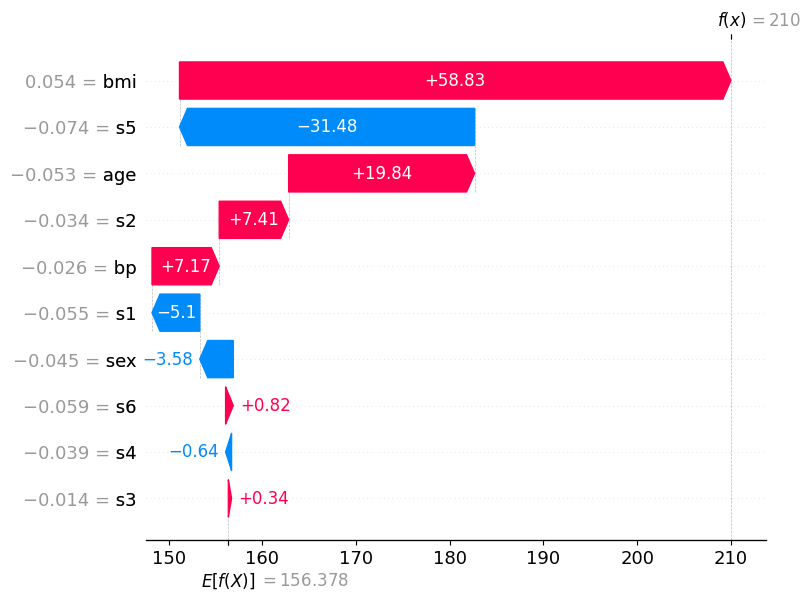

In [105]:
# Waterfall plot of shap values for one single prediction
# f(x): predicted target for that row
# E[f(X)]: average target
shap.plots.waterfall(explanations[0])

In [107]:
# Force plot of shap values for one single prediction
# It's like a stacked waterfall
shap.plots.force(explanations[0])

In [127]:
shap.plots.force(explanations, ordering_keys=explanations.sum(1))

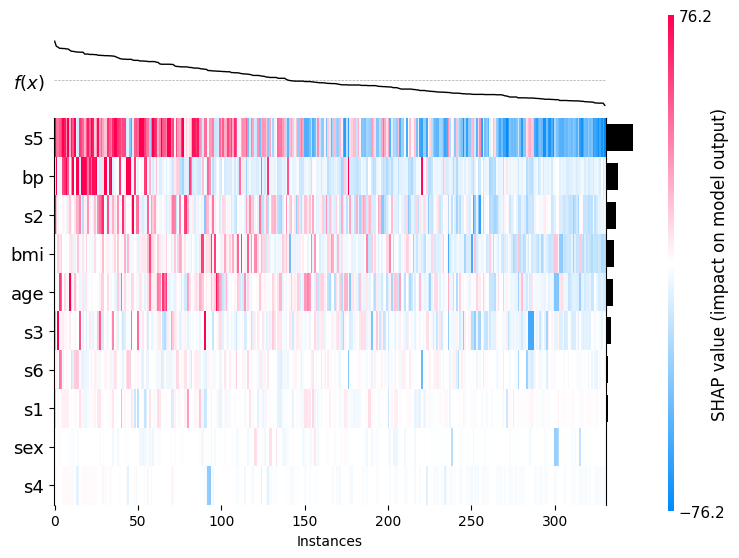

<Axes: xlabel='Instances'>

In [124]:
shap.plots.heatmap(explanations, instance_order=explanations.sum(1))

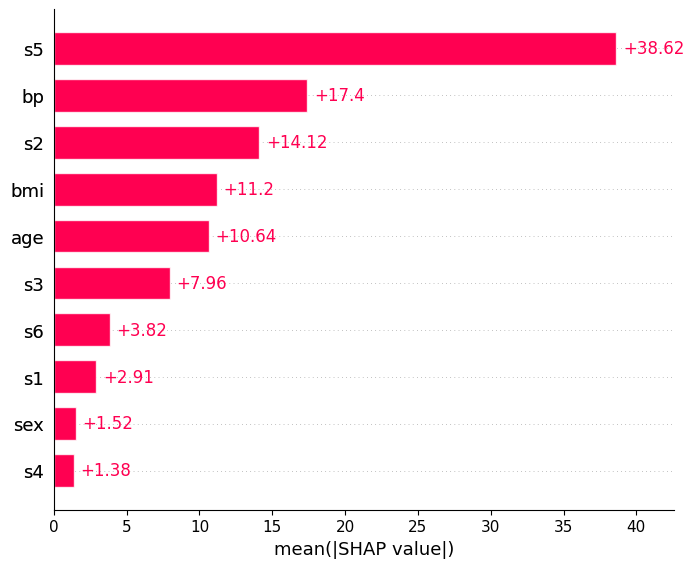

In [108]:
shap.plots.bar(explanations)

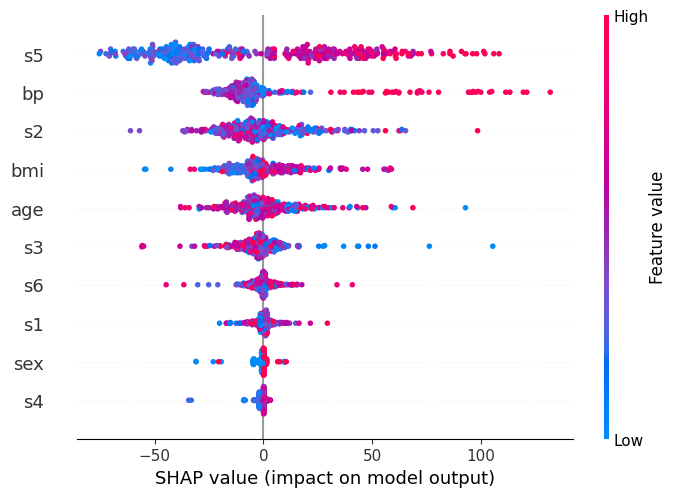

In [110]:
shap.plots.beeswarm(explanations)

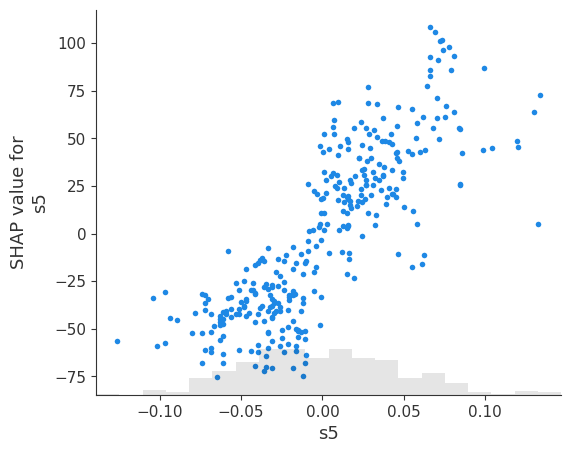

In [112]:
# depednece
# scatter of shap (y) vs one of the features
shap.plots.scatter(explanations[:, 's5'])

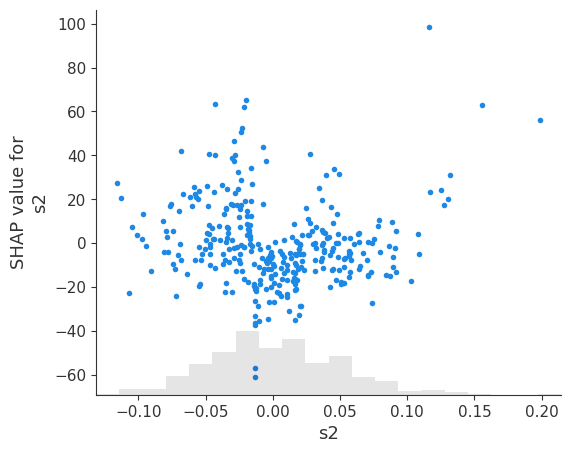

In [115]:
shap.plots.scatter(explanations[:, 's2'])